# Servo simulation draft

Outline for simulating response from two-level ion when driven with a drifting clock laser. Linewidth functions interchangeable.

TODO:
- integrate dead time ($e^{-(t_{meas}/\tau_{ion})}$)
- laser noise & linewidth
- some way to simulate different measurement cycles (LHHL), maybe add an impact on dead time due to servo re-alignment?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks
from scipy.stats import cauchy, binom
from scipy.optimize import curve_fit
import allantools
import sys
sys.path.append('../')
from simul_utils import lineshape, k_p, allan_deviation, sampling_cycle, FWHM, sampled_lineshape
import pandas as pd
import os

Lineshape function used is the ideal Rabi flopping when driven with pi pulses:
\begin{align}
\rho_{ee}(t) = \left( \frac{\pi}{2} \right)^2 \textrm{sinc}^2 \left( \frac{\sqrt{\pi^2 + \delta^2 t^2}}{2} \right)
\end{align} 

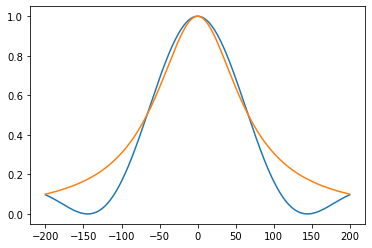

In [23]:
d, step = np.linspace(-200, 200, 1000, retstep=True)
plt.plot(d, lineshape(d, 6e-3, True))
plt.plot(d, lorentzian_lineshape(d, 6e-3, True))

Instead, we can use the Lorenzian lineshape:
    \begin{align}
    L &= \frac{1}{1+x^2} \quad \text{where} \\
    x &= \frac{p-p_0}{w/2} \\
    w &\approx \frac{5}{4} \tau_\pi
    \end{align}

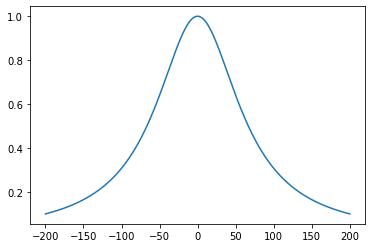

In [22]:
def lorentzian_lineshape(delta, tau_pi, state_prep=False, center=0.):
    fwhm = 0.8/tau_pi
    subsidiary = (delta-center) / (fwhm/2.)
    lorentzian = 1. / (1. + np.square(subsidiary))
    state_coeff = 1 if state_prep else 0.5
    lorentzian *= state_coeff
    return lorentzian
d, step = np.linspace(-200, 200, 1000, retstep=True)
plt.plot(d, lorentzian_lineshape(d, 6e-3, True))

In [19]:
0.8/6e-3

133.33333333333334

The slope ($k_p(\delta, t)$) is calculated using a simple finite differential scheme from the disciminant function. More sophisticated methods could also be used.

The disciminant function $\kappa$ is constructed by sliding the laser offset across the peak and calculating the difference between the probabilities on either side of the peak. $k_p$ is then the slope of the disciminant evaluated at $\delta=0$.
\begin{align}
\kappa(\delta) &= p_B(\delta) - p_R(\delta) \\
k_p &= \left.\frac{d \kappa(\delta)}{d\delta}\right\vert_{\delta = 0}
\end{align}

-0.02276504626112354

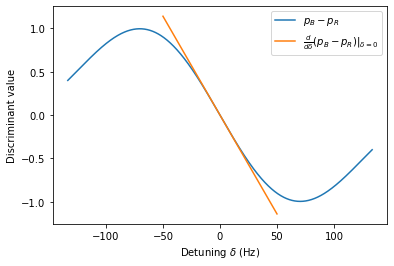

In [3]:
d, step = np.linspace(-200, 200, 10000, retstep=True)
kp, d_k, d = k_p(d, 6e-3, state_prep=True)
plt.plot(d, d_k, label=r"$p_B - p_R$")
d_kp = np.linspace(-50, 50, 100)
tangent = d_kp * kp
plt.plot(d_kp, tangent, label=r"$\frac{d}{d \delta}(p_B - p_R)|_{\delta=0}$")
plt.legend()
plt.xlabel(r"Detuning $\delta$ (Hz)")
plt.ylabel("Discriminant value")
kp

Visualising the result of laser offset on the measured probabilities $p_R$ and $p_B$. Scipy ``peak_widths`` used here to calculate FWHM.

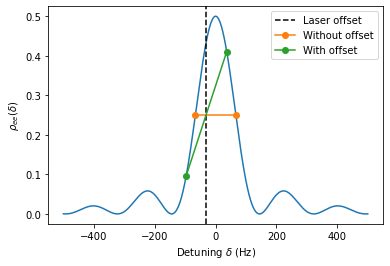

In [4]:
def get_both_ps(d, lineshape_func, t, laser_offset=None):
    l_s =lineshape_func(t, d) # generate lineshape data
    widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5) #get FWMH data
    x_R = d[int(np.rint(widths[2][0]))]
    x_B = d[int(np.rint(widths[3][0]))]
    p_R = p_B = widths[1][0]
    if laser_offset is not None:
        x_R += laser_offset
        x_B += laser_offset
        p_R = lineshape_func(t, x_R)
        p_B = lineshape_func(t, x_B)
    return {'x_R': x_R,
            'x_B': x_B,
            'p_R': p_R,
            'p_B': p_B}

d, step = np.linspace(-500, 500, 1000, retstep=True)
l_s = lineshape(6e-3, d)
widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5)
without_offset = get_both_ps(d, lineshape, 6e-3)
laser_offset = -30
with_offset = get_both_ps(d, lineshape, 6e-3, laser_offset=laser_offset)
plt.plot(d, l_s)
plt.axvline(laser_offset, color='k', linestyle='--', label='Laser offset')
plt.plot([without_offset['x_R'], without_offset['x_B']],[without_offset['p_R'], without_offset['p_B']], marker='o', label='Without offset')
plt.plot([with_offset['x_R'], with_offset['x_B']],[with_offset['p_R'], with_offset['p_B']], marker='o', label='With offset')
plt.xlabel(r"Detuning $\delta$ (Hz)")
plt.ylabel(r"$\rho_{ee}(\delta)$")
plt.legend()

Theoretical Allan deviation from Dubé2015a.
\begin{equation}
\sigma_y(\tau) = -\frac{2 \sqrt{p_X(1-p_X)}}{k_p \eta_0} \sqrt{\frac{T_c}{\tau}}
\end{equation}

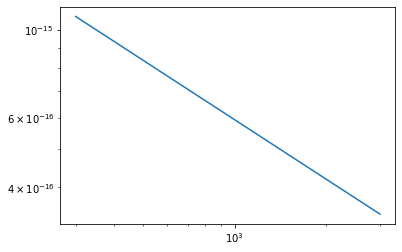

In [5]:
tau_pi = 6e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(d, tau_pi)
taus = np.linspace(300, 3000, 100)
f0 = 444779044095486.5 # Hz, Sr88 SRS
adev = allan_deviation(0.25, kp, f0, T_c, taus)
plt.plot(taus, adev)
plt.xscale("log")
plt.yscale("log")

Sampling function test

In [6]:
T_s = 5 #s
n_m = 100 #number of measurements per cycle
d, step = np.linspace(-500, 500, 1000, retstep=True)
l_s = lineshape(6e-3, d)
sampling_cycle(0, T_s, 100, FWHM(l_s, d)/2, 6e-3)

(0.3, 0.00010000000000331966, 0.0001)

### Values from sampled and fitted lineshape

Fitted pulse length (width): 0.006043415869189139, center: -0.22219026574737497


132.13213213213214

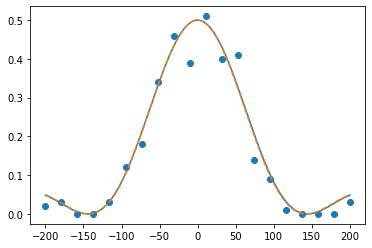

In [7]:
d = np.linspace(-200, 200, 1000)
d_sample = np.linspace(-200, 200, 20)
s_shape = sampled_lineshape(lineshape, d_sample)
plt.plot(d, lineshape(d, 6e-3, False))
plt.scatter(d_sample, s_shape)

# fit a function for fwhm
popt, pcov = curve_fit(lambda d, t, c: lineshape(d, t, False, c), d_sample, s_shape, p0=[1e-2, 0.])
fit_shape = lineshape(d, popt[0], False, popt[1])
plt.plot(d, fit_shape, linestyle='--')
print(f"Fitted pulse length (width): {popt[0]}, center: {popt[1]}")
FWHM(fit_shape, d)

### Sensitivity of FWHM when fitting

Text(0.5, 1.0, 'Initial guesses: [0.01, 0.0], failed fits: 0, n: 1000')

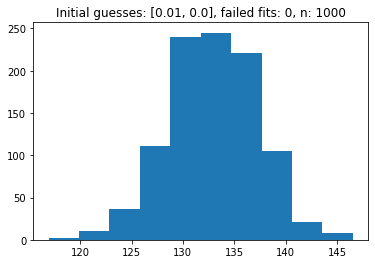

In [8]:
init_guess = [1e-2, 0.]
failed = 0
n_fits = 1000
ts = np.zeros(n_fits)
cs = np.zeros(n_fits)
widths = np.zeros(n_fits)
d = np.linspace(-200, 200, 1000)
d_sample = np.linspace(-200, 200, 20)

for i in range(n_fits):
    s_shape = sampled_lineshape(lineshape, d_sample)
    while True:
        try:
            popt, pcov = curve_fit(lambda d, t, c: lineshape(d, t, False, c), d_sample, s_shape, p0=init_guess)
        except RuntimeError:
            failed += 1
            break
        else:
            ts[i] = popt[0]
            cs[i] = popt[1]
            widths[i] = FWHM(lineshape(d, popt[0], False, popt[1]), d)
            break

plt.hist(widths)
plt.title(f"Initial guesses: {init_guess}, failed fits: {failed}, n: {n_fits}")

### Simulations

#### Single peak, optimal gain

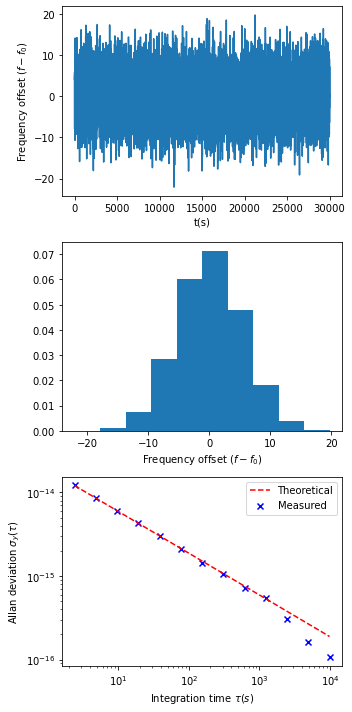

In [9]:
# main simulation loop
n_s = 100 # number of samples
tau_pi = 6e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c
initial_offset = 0 # Hz
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=T_c, stop=max_tau, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_corrected = np.zeros(len(t)) # servo-corrected frequency
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(d, tau_pi)
fwhm = FWHM(lineshape(d, tau_pi), d)
p_X = 0.5 if state_preparation else 0.25
g = -2 * p_X / kp # gain
f_cavity = 0.
f_corrected = initial_offset
for i in range(0, len(t)):
    tau = t[i]
    #print(f)
    p_B, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_s, fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    p_R, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_s, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    #print(f"p_R: {p_R}, p_B: {p_B}, without gain: {(p_B - p_R) / (p_B + p_R)}")
    eta_cavity[i] = f_cavity
    E = g * (p_B - p_R) / (p_B + p_R)
    #print(f"Current f offset: {f}; error signal: {E}")
    f_corrected = f_corrected + E
    eta_corrected[i] = f_corrected

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
ax[0].plot(t, eta_corrected)
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[0].set_xlabel("t(s)")
ax[1].hist(eta_corrected, density=True)
ax[1].set_xlabel(r"Frequency offset ($f-f_0$)")
(taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.25, kp, f0, T_c, taus)
ax[2].scatter(taus, adevs, color='b', marker='x', label="Measured")
ax[2].plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[2].set_xlabel(r"Integration time $\tau (s)$")
ax[2].legend()
fig.tight_layout()

In [11]:
print(f'{g}, {fwhm}')

43.92705038301414, 133.1173311733117


### Gain & $k_p$ from sampling

In [18]:
n_m = 100
time_step = 1
detunings = np.linspace(start=f0 + n_m,
                                stop=f0 + (n_m * laser_drift * time_step),
                                num=n_m)

Sampled FWHM: 127.1572715727157, center: -6.504514202233891


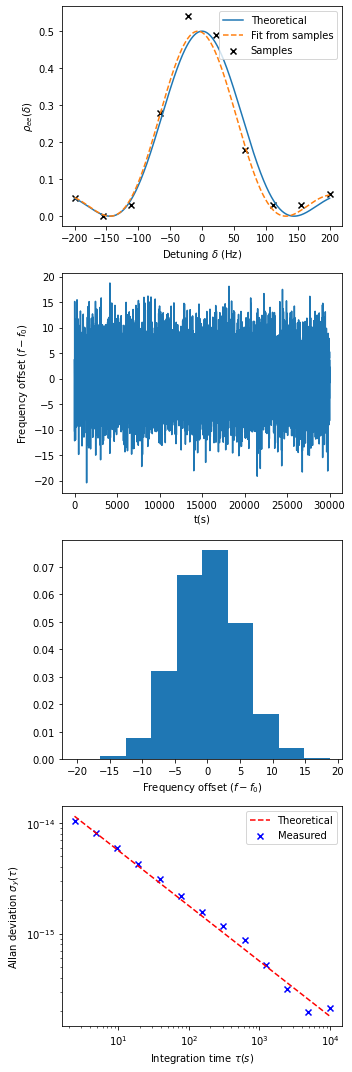

In [19]:
# main simulation loop with sampled FWHM
n_s = 100 # number of samples
tau_pi = 6e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c
initial_offset = 0 # Hz
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=T_c, stop=max_tau, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_corrected = np.zeros(len(t)) # servo-corrected frequency
d, step = np.linspace(-200, 200, 100000, retstep=True)
d_sample = np.linspace(-200, 200, 10)
l_sample = sampled_lineshape(lineshape, 
                             d_sample,
                             tau_pi=tau_pi,
                             state_prep=state_preparation,
                             samples_per_point=100)
popt, pcov = curve_fit(lambda d, t, c: lineshape(d, t, False, c), d_sample, l_sample, p0=[1e-2, 0.])
fit_shape = lineshape(d, popt[0], state_preparation, popt[1])
kp, _, _ = k_p(d, t=popt[0], n=1000, state_prep=state_preparation, center=popt[1])
fwhm = FWHM(fit_shape, d)
p_X = 0.5 if state_preparation else 0.25
g = -2 * p_X / kp # gain
f_cavity = 0.
f_corrected = initial_offset
for i in range(0, len(t)):
    tau = t[i]
    #print(f)
    p_B, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_s, fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    p_R, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_s, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    #print(f"p_R: {p_R}, p_B: {p_B}, without gain: {(p_B - p_R) / (p_B + p_R)}")
    eta_cavity[i] = f_cavity
    E = g * (p_B - p_R) / (p_B + p_R)
    #print(f"Current f offset: {f}; error signal: {E}")
    f_corrected = f_corrected + E
    eta_corrected[i] = f_corrected

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5, 15))
ax[0].plot(d, lineshape(d, tau_pi, state_prep=state_preparation), label="Theoretical")
ax[0].scatter(d_sample, l_sample, marker='x', color='k', label="Samples")
ax[0].plot(d, fit_shape, linestyle='--', label="Fit from samples")
ax[0].set_xlabel(r"Detuning $\delta$ (Hz)")
ax[0].set_ylabel(r"$\rho_{ee}(\delta)$")
ax[0].legend()
ax[1].plot(t, eta_corrected)
ax[1].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[1].set_xlabel("t(s)")
ax[2].hist(eta_corrected, density=True)
ax[2].set_xlabel(r"Frequency offset ($f-f_0$)")
(taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.25, kp, f0, T_c, taus)
ax[3].scatter(taus, adevs, color='b', marker='x', label="Measured")
ax[3].plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
ax[3].set_yscale('log')
ax[3].set_xscale('log')
ax[3].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[3].set_xlabel(r"Integration time $\tau (s)$")
ax[3].legend()
fig.tight_layout()
print(f"Sampled FWHM: {fwhm}, center: {popt[1]}")

### Six peaks, sample initial settings

In [20]:
n_s = 100 # number of samples
tau_pi = 4e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c
initial_offset = 0 # Hz
state_preparation = False
p_X = 0.5 if state_preparation else 0.25
max_tau = 30000 # s, max integration time
n_c = 6 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=0, stop=max_tau+n_c*T_s, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_peaks = np.zeros((len(t), n_c)) # servo-corrected frequency for peaks
eta_peak_centers = np.zeros((len(t), int(n_c/2)))
eta_trans = np.zeros(len(t))
d, step = np.linspace(-200, 200, 100000, retstep=True)
d_sample = np.linspace(-200, 200, 10)
# initialize centers, k_ps and gains
f_cavity = 0. # laser initially in the center
f_centers = np.zeros(n_c)
k_ps = np.zeros(n_c)
servo_gains = np.zeros(n_c)
fwhms = np.zeros(n_c)
for center in range(n_c):
    l_sample = sampled_lineshape(lineshape, 
                                 d_sample,
                                 tau_pi=tau_pi,
                                 state_prep=state_preparation,
                                 samples_per_point=100)
    popt, pcov = curve_fit(lambda d, t, c: lineshape(d, t, False, c), d_sample,
                           l_sample, p0=[1e-2, 0.])
    fit_shape = lineshape(d, popt[0], state_preparation, popt[1])
    k_ps[center], _, _ = k_p(d, t=popt[0], n=1000, state_prep=state_preparation,
                           center=popt[1])
    fwhms[center] = FWHM(fit_shape, d)
    servo_gains[center] = -2 * p_X / kp # gain
    f_centers[center] = popt[1]

eta_peaks[0,:] = f_centers

for i in range(1, len(t)):
    tau = t[i]
    #print(f)
    p_B, f_centers, delta_cavity = sampling_cycle(f_centers, T_s, n_s, fwhms/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity[0]
    p_R, f_centers, delta_cavity = sampling_cycle(f_centers, T_s, n_s, -fwhms/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity[0]
    eta_cavity[i] = f_cavity
    discriminant = np.divide(p_B - p_R, p_B + p_R)
    E = np.multiply(servo_gains, discriminant)
    f_centers += E
    eta_peaks[i, :] = f_centers
    eta_peak_centers[i, :] = (f_centers[1::2] + f_centers[::2])/2. 
    eta_trans[i] = np.mean(eta_peak_centers[i, :])
    f_centers += ((n_c-1)/n_c) * T_s * laser_drift
    f_centers += ((n_c-1)/n_c) * T_s * laser_drift

NameError: name 'taus_r' is not defined

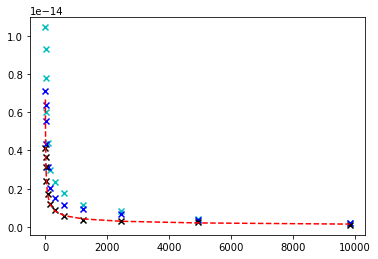

In [21]:
(taus, adevs_c1, errors, ns) = allantools.oadev(eta_peaks[:, 0]/f0, data_type='freq', rate=1./(T_s * n_c))
(_, adevs_p1, errors, ns) = allantools.oadev(eta_peak_centers[:, 0]/f0, data_type='freq', rate=1./(T_s * n_c))
(_, adevs_t, errors, ns) = allantools.oadev(eta_trans/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.25, kp, f0, T_c, taus)
plt.scatter(taus, adevs_c1, color='c', marker='x', label="Single peak")
plt.scatter(taus, adevs_p1, color='b', marker='x', label="Single peak pair")
plt.scatter(taus, adevs_t, color='k', marker='x', label="Transition (3 pairs)")
plt.plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
plt.scatter(taus_r, adevs_r, label='Measurement')
plt.ylabel(r"Allan deviation $\sigma_y(\tau)$")
plt.xlabel(r"Integration time $\tau (s)$")
plt.yscale("log")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.1, 1.01))

### Reproducing Dubé2015a effect of incorrect gain

In [24]:
lineshape = lorentzian_lineshape
tau_pi = 200e-3 # s, pulse length
n_s = 100
T_c = tau_pi + 28e-3 # s, single cycle length
T_s = 8 #s, total sampling time
initial_offset = 0 # Hz
state_preparation = True
max_tau = 1000 # s, max integration time
n_c = 6 # number of cycles per correction
laser_drift = -1e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=n_c*T_s, stop=max_tau, step=n_c*T_s)
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(d, tau_pi, state_prep=state_preparation)
fwhm = FWHM(lineshape(d, tau_pi, state_prep=state_preparation), d)
p_X = 0.5 if state_preparation else 0.25
#g0 = -2 * p_X / kp # optimal gain
g0 = fwhm/2.
gains = [0.7, 0.85, 1., 1.25, 1.5, 1.9]
eta_theoretical = np.zeros((len(t), len(gains)))
for gi in range(0, len(gains)):
    f_theoretical = initial_offset
    g = gains[gi]
    for i in range(1, len(t)):
            f_theoretical += laser_drift * n_s * T_c
            p_B0 = lineshape(f_theoretical+fwhm/2., tau_pi, state_preparation)
            p_R0 = lineshape(f_theoretical-fwhm/2., tau_pi, state_preparation)
            E0 = g * g0 * (p_B0 - p_R0) / (p_B0 + p_R0)
            f_theoretical += E0
            eta_theoretical[i, gi] = f_theoretical

(-0.02, 0.02)

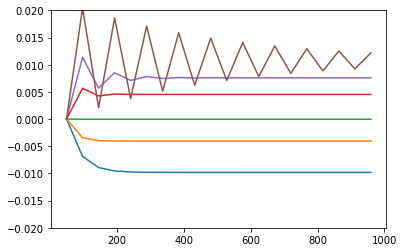

In [25]:
plt.plot(t, eta_theoretical)
plt.ylim([-20e-3, 20e-3])

### Effect of different sampling sequences

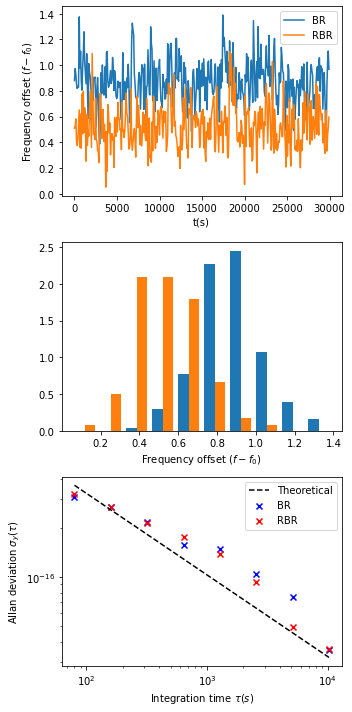

In [26]:
# main simulation loop
n_s = 100 # number of samples
tau_pi = 200e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c
initial_offset = 0 # Hz
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=T_c, stop=max_tau, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_corrected = np.zeros(len(t)) # servo-corrected frequency
eta_alternative_model = np.zeros(len(t)) # servo-corrected frequency
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(d, tau_pi)
fwhm = FWHM(lineshape(d, tau_pi), d)
p_X = 0.5 if state_preparation else 0.25
#g = -2 * p_X / kp # gain
g = fwhm/2.
f_cavity = 0.
f_corrected = f_corrected2 = initial_offset
for i in range(0, len(t)):
    tau = t[i]
    #print(f)
    p_B, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_s, fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    p_R, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_s, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity

    #print(f"p_R: {p_R}, p_B: {p_B}, without gain: {(p_B - p_R) / (p_B + p_R)}")
    eta_cavity[i] = f_cavity
    E = g * (p_B - p_R) / (p_B + p_R)
    #print(f"Current f offset: {f}; error signal: {E}")
    f_corrected = f_corrected + E
    eta_corrected[i] = f_corrected
    
    p_R1, f_corrected2, delta_cavity = sampling_cycle(f_corrected2, T_s//2, n_s//2, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    p_B, f_corrected2, delta_cavity = sampling_cycle(f_corrected2, T_s, n_s, fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    p_R2, f_corrected2, delta_cavity = sampling_cycle(f_corrected2, T_s//2, n_s//2, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    p_R = np.mean([p_R1, p_R2])
    E = g * (p_B - p_R) / (p_B + p_R)
    #print(f"Current f offset: {f}; error signal: {E}")
    f_corrected2 = f_corrected2 + E
    eta_alternative_model[i] = f_corrected2

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
ax[0].plot(t, eta_corrected, label='BR')
ax[0].plot(t, eta_alternative_model, label='RBR')
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[0].set_xlabel("t(s)")
ax[0].legend()
ax[1].hist([eta_corrected, eta_alternative_model], density=True)
ax[1].set_xlabel(r"Frequency offset ($f-f_0$)")
(taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
(taus2, adevs2, errors, ns) = allantools.oadev(eta_alternative_model/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.25, kp, f0, T_c, taus)
ax[2].scatter(taus, adevs, color='b', marker='x', label="BR")
ax[2].scatter(taus2, adevs2, color='r', marker='x', label="RBR")
ax[2].plot(taus, theoretical_adev, color='k', linestyle='--', label="Theoretical")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[2].set_xlabel(r"Integration time $\tau (s)$")
ax[2].legend()
fig.tight_layout()

### Compare to actual data

In [155]:
# load data
data_dir = '../data/2020-06-16_clockrun_4ms/'
f_names = [x for x in os.listdir(data_dir) if '.' in x]
data = {}
for name in f_names:
    col_names = ['t', 'f']
    key = name.partition('.')[0]
    data[key] = pd.read_csv(data_dir + name, sep='  ', header=None, names=col_names)

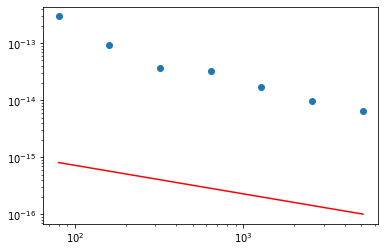

In [120]:
df = data['computed_center_C1'].copy()
stable_idx = (df['t']).ge(59015.85).idxmax()
df = df[stable_idx:]
df['f_e'] = df['f'] - f0
df['f_e'] = df['f_e'] - np.mean(df['f_e'])
T_c = np.mean(np.diff(df['t']))
total_t = (df['t'].iloc[-1] - df['t'].iloc[0]) * 1e5
n = len(df.index)
(taus_r, adevs_r, errors, ns)=allantools.oadev(np.array((df['f_e'])/f0), data_type='freq', rate=n/total_t)
kp_r, _, _ = k_p(np.linspace(-200, 200, 100), 4e-3)
theoretical_adev = allan_deviation(0.25, kp_r, f0, T_c, taus_r)
plt.scatter(taus_r, adevs_r)
plt.plot(taus_r, theoretical_adev, color='r')
plt.xscale("log")
plt.yscale("log")